In [1]:
import re
import numpy as np
from collections import Counter

import string

from sklearn.model_selection import train_test_split
from keras import regularizers
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Embedding, LSTM, Conv1D, MaxPooling1D

import matplotlib.pyplot as plt
%matplotlib inline

import os
from metrics import make_roc_pr_plot, plot_learning_curves, reverse_embedding
from sklearn.metrics import precision_recall_curve, roc_curve, auc

Using TensorFlow backend.


In [2]:
#def remove_punctuation(s):
#    regex = re.compile('[%s]' % re.escape(string.punctuation))
#    return regex.sub('', s)

#def replace_numbers(s):
#    s = re.sub("\d", "x", s)
#    return s

#def clean_string(s):
#    """
#    string cleaning for dataset
#    Every dataset is lower cased except
#    """
#    s = remove_punctuation(s)
#    s = replace_numbers(s)
#    return s

def remove_space_before_comma_and_period(s):
    """
    This function removes the space before commas and periods. The spaces are probably 
    placed to make machine processing easier, but I would like the formatting to be consistent
    with normal use to I can reuse functions for cleaning strings.
    """
    return re.sub("\s,", ',', s)

def define_vocabulary(no_comma_sentences, max_vocab):
    """
        0 is used for no word
        1 is used for word unknown
        So vocabulary stats at 2
    """
    corpus = ' '.join(no_comma_sentences)
    c = Counter(corpus.split())
    vocab_len = len(c)+2
    most_common_words = c.most_common(max_vocab)
    vocabulary = {}
    reverse_vocabulary = {}
    for idx, item in enumerate(most_common_words):
        word = item[0]
        vocabulary[word] = idx+2
        reverse_vocabulary[idx+2] = word
    return vocabulary, reverse_vocabulary

def get_y(sentence, max_len):
    words = sentence.split()
    y = np.zeros((1, max_len))
    for idx, word in enumerate(words):
        if (',' in word) and (idx<max_len-1):
            y[0, idx] = 1
                
    return y

def embed_sentence(sentence, vocabulary, max_len):
    embedded = []
    try:
        sentence_crop = sentence.split()[:max_len]
    except:
        sentence_crop = sentence.split()
    for word in sentence_crop:
        if word in vocabulary:
            word_idx = vocabulary[word]
            embedded.append(word_idx)
        else:
            embedded.append(1)
    while len(embedded)<max_len:
        embedded.append(0)
    return embedded


def pre_process(sentences, max_len, vocabulary):
    X = []
    Y = []
    for sentence in sentences:
        sentence = remove_space_before_comma_and_period(sentence)
        try:
            y = get_y(sentence, max_len)
        except:
            print(sentence)
            print(len(sentence.split()))
            break
        sentence = sentence.replace(',', '')
        embedded_sentence = embed_sentence(sentence, vocabulary, max_len)
        X.append(embedded_sentence)
        Y.append(y)
    Y = np.concatenate(Y, axis=0)
    return X, Y        

In [3]:
max_len = 50
max_vocab = 6000
num_datafiles = 40
EMBEDDING_DIM = 128
epochs = 7
batch_size = 16

In [4]:
path_to_files = 'corpera/europarl_raw/danish/'
all_files = [files for (path, dirs, files) in os.walk(path_to_files)][0]
all_sentences = []
for file in all_files[:num_datafiles]:
    if file.endswith(".da"):
        with open(path_to_files + file) as f:
            sentences = f.readlines()
            for sentence in sentences:
                all_sentences.append(sentence)
                
print(len(all_sentences))

94784


In [5]:
cleaned_sentences = [remove_space_before_comma_and_period(sentence) for sentence in all_sentences]
vocabulary, reverse_vocabulary = define_vocabulary(cleaned_sentences, max_vocab)

In [6]:
X, Y = pre_process(all_sentences, max_len, vocabulary)

# Split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

In [8]:
model = Sequential()
model.add(Embedding(len(vocabulary)+2, EMBEDDING_DIM, input_length=max_len))
model.add(Dropout(0.5))
model.add(Conv1D(filters=64,
                 kernel_size=5,
                 padding='valid',
                 activation='relu',
                 strides=1))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(50))
model.add(Dense(max_len))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 128)           768256    
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 46, 64)            41024     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 11, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                23000     
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
activation_1 (Activation)    (None, 50)                0         
Total para

In [10]:
history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, y_test))

Train on 85305 samples, validate on 9479 samples
Epoch 1/7
85305/85305 [==============================] - 249s - loss: 0.1138 - acc: 0.9657 - val_loss: 0.1010 - val_acc: 0.9669
Epoch 2/7
85305/85305 [==============================] - 249s - loss: 0.0943 - acc: 0.9685 - val_loss: 0.0867 - val_acc: 0.9715
Epoch 3/7
85305/85305 [==============================] - 250s - loss: 0.0775 - acc: 0.9747 - val_loss: 0.0712 - val_acc: 0.9766
Epoch 4/7
85305/85305 [==============================] - 244s - loss: 0.0672 - acc: 0.9779 - val_loss: 0.0646 - val_acc: 0.9792
Epoch 5/7
85305/85305 [==============================] - 247s - loss: 0.0607 - acc: 0.9800 - val_loss: 0.0591 - val_acc: 0.9809
Epoch 6/7
85305/85305 [==============================] - 250s - loss: 0.0558 - acc: 0.9820 - val_loss: 0.0555 - val_acc: 0.9827
Epoch 7/7
85305/85305 [==============================] - 248s - loss: 0.0523 - acc: 0.9833 - val_loss: 0.0532 - val_acc: 0.9835


Final training loss   0.0523234178205
Final validation loss 0.05321635052


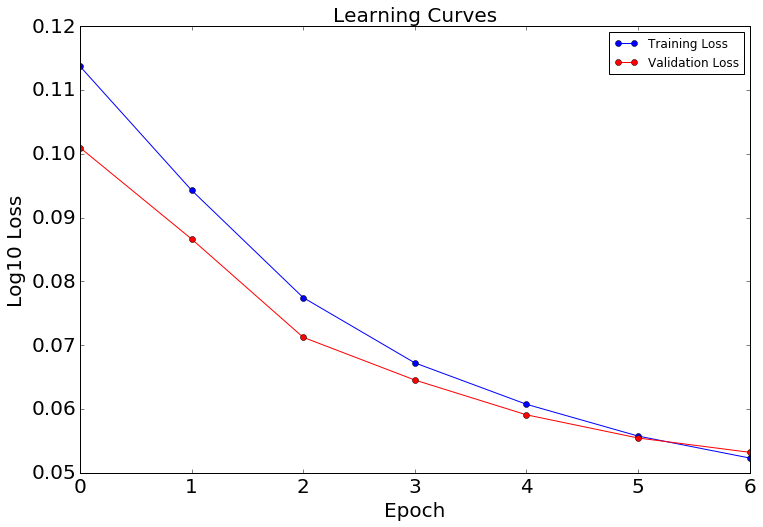

In [11]:
plot_learning_curves(history)

In [12]:
y_hat = model.predict_proba(X_test)

9472/9479 [============================>.] - ETA: 0s

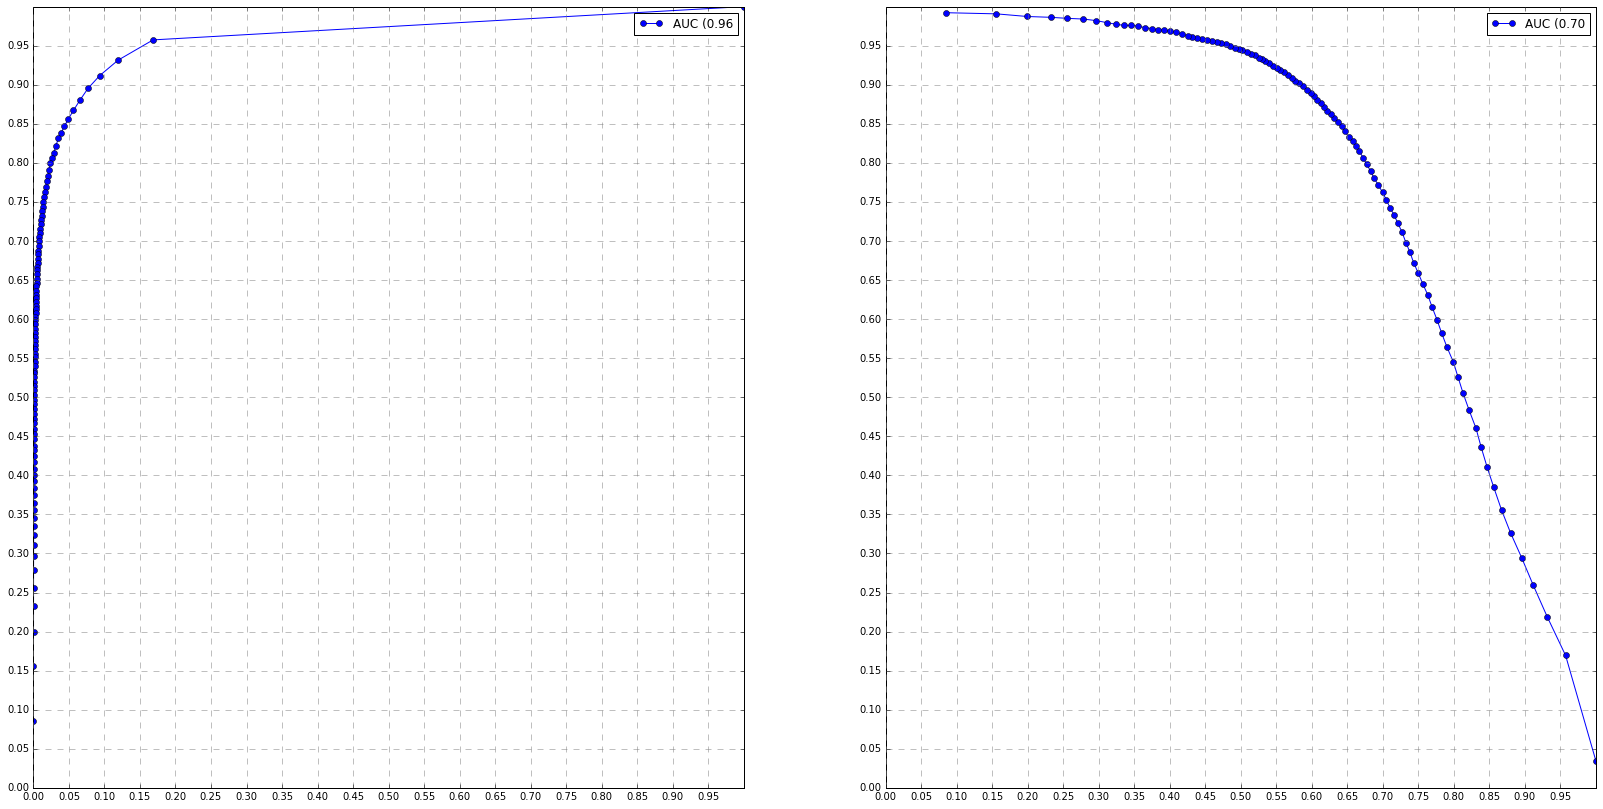

In [13]:
make_roc_pr_plot(y_test, y_hat)

# Write function that gets a fp or fn from the test set

In [14]:
reverse_vocabulary[0] = ''
reverse_vocabulary[1] = 'UNKNOWN'

In [16]:
idx = 10 #15
reverse_embedding(X_test[idx], y_test[idx], reverse_vocabulary, y_hat[idx], threshold=0.3)

Vi har nogle midler, [tp] vi kan bruge over for Rusland, [tp] hvis vi vælger at bruge dem, [tp] men vi vælger ikke at bruge dem .                          
